# A fast velocity computation

## Makes a synthetic set

In [1]:
import MotionClouds as mc
N_X, N_X_up, N_T = 64, 512, 256
fx, fy, ft = mc.get_grids(N_X, N_X_up, 1)
sf_0=0.05
env = mc.envelope_gabor(fx, fy, ft, sf_0=sf_0, B_sf=sf_0, V_X=0., V_Y=0., B_V=0)
x = 2 * mc.rectif(mc.random_cloud(env, seed=1973))[0, :] - 1

In [2]:
mc.envelope_gabor?

Signature:
mc.envelope_gabor(
    fx,
    fy,
    ft,
    V_X=1.0,
    V_Y=0.0,
    B_V=0.5,
    sf_0=0.125,
    B_sf=0.1,
    loggabor=True,
    theta=0.0,
    B_theta=0.19634954084936207,
    alpha=0.0,
    **kwargs,
)
Docstring:
Returns the Motion Cloud kernel, that is the product of:
    * a speed envelope
    * an orientation envelope
    * an orientation envelope
File:      /usr/local/lib/python3.9/site-packages/MotionClouds.py
Type:      function


In [3]:
import numpy as np

In [4]:
def sigmoid(x):
    return 2 / (1 + np.exp(-x)) - 1
slope = 2. 
z = np.tanh(slope*x)

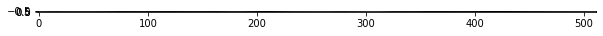

In [5]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(z.T, cmap=plt.gray())

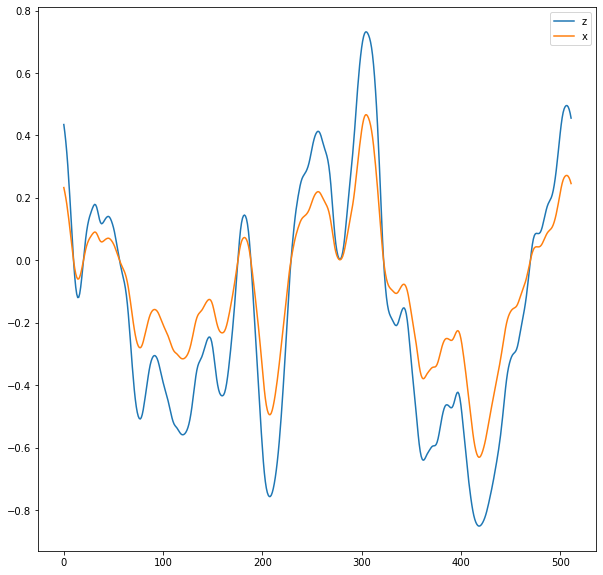

In [6]:
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.plot(z, label='z')
_ = ax.plot(x, label='x')
plt.legend();

In [7]:
noise = 0.025
I_noise = noise * np.random.randn(N_X, N_T)

In [8]:
up = int(N_X_up/N_X)

In [9]:
I = np.zeros((N_X, N_T))
for i_T in range(N_T):
    I[:, i_T] = np.roll(z, int(i_T*N_X_up/N_T))[::up, 0] 
I += I_noise

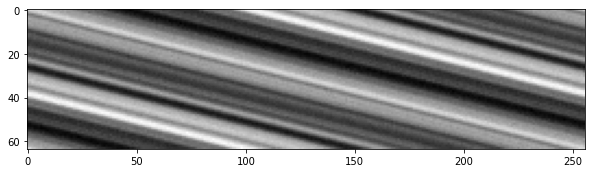

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(I, cmap=plt.gray())

## transform to events

In [11]:
print(I.min(), I.max())

-0.9222774753058417 0.7886118776690438


In [12]:
#I[20:40, 40:80] = 0
#Ix = np.gradient(I, axis=0)
It = np.gradient(I, axis=1)

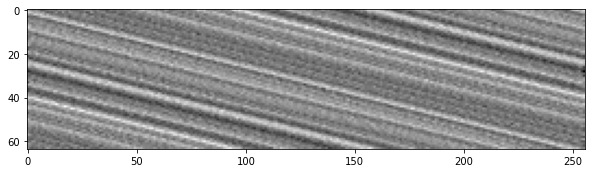

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(It, cmap=plt.gray())

In [14]:
print(It.min(), It.max())

-0.22565733591779472 0.19785328511372577


In [15]:
threshold = 0.1

In [16]:
It_ = It.copy()
It_event = np.zeros((N_X, N_T))
for i_T in range(N_T-1):
    It_event[:, i_T] = 1. * (It_[:, i_T] > threshold) - 1. * (It_[:, i_T] < -threshold)
    It_[:, i_T+1] -= threshold * It_event[:, i_T]
#It_event[:, -1] = 0

In [17]:
print(It_event.min(), It_event.max())
print(It_.min(), It_.max())

-1.0 1.0
-0.16198099668727528 0.18982784245063053


In [ ]:
np.lookfor('seismic')

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(It_event, cmap=plt.cm.seismic, vmin=-1, vmax=1)

In [ ]:
It_event[:, 0], It_event[:, 10], It_event[:, -1], It_event.shape

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(It_, cmap=plt.hot(), vmin=-1, vmax=1)

## motion compensated transform on events

In [ ]:
It_v = np.zeros((N_X, N_T))
V = 1.
for i_T in range(N_T):
    It_v[:, i_T] = np.roll(It_event[:, i_T], -int(V*N_X/N_T*i_T))

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(It_v, cmap=plt.cm.seismic, vmin=-1, vmax=1)

In [ ]:
It_v[:, 0]

In [ ]:
p_V_plus = np.sum(It_v==1, axis=1)*1.
p_V_minus = np.sum(It_v==-1, axis=1)*1.

p_V_plus /= np.sum(p_V_plus)
p_V_minus /= np.sum(p_V_minus)

In [ ]:
np.sum(p_V_minus)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(p_V_plus, c='r')
ax.plot(p_V_minus, c='b')
ax.set_ylim(0)

In [ ]:
entropy = -np.sum( p_V_minus * np.log2(p_V_minus + 1.*(p_V_minus==0)) )
entropy += -np.sum( p_V_plus * np.log2(p_V_plus + 1.*(p_V_plus==0)) )

In [ ]:
entropy

## transform as an event list

In [ ]:
It_event.shape

In [ ]:
import torch

In [ ]:
torch.nonzero(torch.Tensor(It_event)).shape, torch.nonzero(torch.Tensor(It_event==1)).shape, torch.nonzero(torch.Tensor(It_v==-1)).shape

In [ ]:
torch.nonzero(torch.Tensor(It_event))[:10, :]

x, t, p

In [ ]:
events_neg = torch.nonzero(torch.Tensor(It_event==-1))
events_neg.shape, torch.ones(events_neg.shape[0], 1).shape

In [ ]:
events_neg = torch.hstack((events_neg, -1 * torch.ones(events_neg.shape[0], 1, dtype=int)))
events_neg.shape

In [ ]:
events_pos = torch.nonzero(torch.Tensor(It_event==1))
events_pos = torch.hstack((events_pos, torch.ones(events_pos.shape[0], 1, dtype=int)))
events_pos.shape

In [ ]:
events = torch.vstack((events_pos, events_neg))
events.shape

In [ ]:
events[:10, :]

In [ ]:
times, indices = torch.sort(events[:, 1])
events = events[indices, :]

In [ ]:
# x, t, p
events[:10, :]

Visual check

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(It_event, cmap=plt.cm.seismic, vmin=-1, vmax=1)

In [ ]:
It_event_ = torch.zeros((N_X, N_T))
It_event_[events[:, 0], events[:, 1]] = 1. * events[:, 2]

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(It_event_, cmap=plt.cm.seismic, vmin=-1, vmax=1)

## construction of a constraint

In [ ]:
events.shape

In [ ]:
x_ = torch.linspace(-10, N_X+10, 100)
x = torch.remainder(x_, N_X)
N_X, x.min(), x.max()

In [ ]:
plt.plot(x_, x)

https://en.cppreference.com/w/cpp/numeric/math/fmod

In [ ]:
u = 1.
events_u = 1 * events.clone().detach()
events_u[:, 0] = torch.remainder(events[:, 0] - u*N_X/N_T*events[:, 1], N_X)

In [ ]:
events_u[:, 0].shape

In [ ]:
It_event_ = torch.zeros((N_X, N_T))
It_event_[events_u[:, 0], events_u[:, 1]] = 1. * events_u[:, 2]

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(It_event_, cmap=plt.cm.seismic, vmin=-1, vmax=1)

Compute occurences of events in space:


In [ ]:
x = events[:, 0] - 1. * u*N_X/N_T*events[:, 1]
x

In [ ]:
x = torch.remainder(x , N_X)
x, x.shape

In [ ]:
d = (x[:, None] - x[None, :])**2

In [ ]:
plt.matshow(d);

In [ ]:
d.argmin(axis=1)

In [ ]:
1000 * torch.eye(x.shape[0])

In [ ]:
d = (x[:, None] - x[None, :])**2 + N_X**2 * torch.eye(x.shape[0])

In [ ]:
d.argmin(axis=1)

In [ ]:
d_min, ind = d.min(axis=1)
d_min

In [ ]:
import torch.nn.functional as F
from torch import nn

In [ ]:
mp = nn.MaxPool1d(x.shape[0])
mp

In [ ]:
d.unsqueeze(0).shape

In [ ]:
mp(-d.unsqueeze(0)).shape

In [ ]:
mp(-d).shape

In [ ]:
torch.sum(-mp(-d))

In [ ]:
d_min = -F.max_pool1d(mp(-d), 1)
d_min.shape

In [ ]:
events[:, 2] == 1

In [ ]:
events[events[:, 2] == 1, 0].shape, events[events[:, 2] == -1, 0].shape

In [ ]:
p = -1
ind_p = events[:, 2] == p
x = events[ind_p, 0] - 1. * u*N_X/N_T*events[ind_p, 1]
x = torch.remainder(x , N_X)
d = (x[:, None] - x[None, :])**2 + N_X**2 * torch.eye(x.shape[0])        
d_min = -F.max_pool1d(-d, x.shape[0])

In [ ]:
d_min.shape, d.shape

In [ ]:
for u in [0, .5, 1, 1.5]:
    for p in [-1, 1]:
        ind_p = events[:, 2] == p
        x = events[ind_p, 0] - 1. * u*N_X/N_T*events[ind_p, 1]
        x = torch.remainder(x , N_X)
        d = (x[:, None] - x[None, :])**2 + N_X**2 * torch.eye(x.shape[0])        
        #d_min = -F.max_pool1d(-d, x.shape[0])
        #d_min, ind = d.min(axis=1)
        print(f'{u=}, {p=}, loss={d.mean().item():.2f}')

## gradient descent optimization

In [ ]:
import torch
torch.set_default_tensor_type("torch.DoubleTensor")

In [ ]:
class EMD(torch.nn.Module):
    def __init__(self, u=0.5):
        super(EMD, self).__init__()
        self.u = torch.nn.Parameter(u * torch.ones(1), requires_grad=True)
        self.polarities = [-1, 1]
    def forward(self, events):
        loss = 0
        for p in self.polarities:
            ind_p = events[:, 2] == p
            x = events[ind_p, 0] - 1. * self.u*N_X/N_T*events[ind_p, 1]
            x = torch.remainder(x , N_X)
            d = (x[:, None] - x[None, :])**2 + N_X**2 * torch.eye(x.shape[0])        
            d_min = -F.max_pool1d(-d, x.shape[0])
            loss += torch.sum(d_min)
        return loss

In [ ]:
class EMD(torch.nn.Module):
    def __init__(self, u=0.5):
        super(EMD, self).__init__()
        self.u = torch.nn.Parameter(u * torch.ones(1), requires_grad=True)
        self.polarities = [-1, 1]
    def forward(self, events):
        loss = 0
        for p in self.polarities:
            ind_p = events[:, 2] == p
            x = events[ind_p, 0] - 1. * self.u*N_X/N_T*events[ind_p, 1]
            x = torch.remainder(x , N_X)
            d = (x[:, None] - x[None, :])**2
            loss += torch.mean(d)
        return loss

In [ ]:
learning_rate = 0.001
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 10 + 1

def fit_data(events, learning_rate=learning_rate, 
             num_epochs=num_epochs, betas=betas, verbose=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    N_X, N_T = It_event.shape
    P_uniform = torch.ones(N_X) / N_X
    events = events.to(device)
        
    emd = EMD()
    emd = emd.to(device)
    emd.train()
    
    optimizer = torch.optim.Adam(emd.parameters(), lr=learning_rate, betas=betas)
    #optimizer = torch.optim.SGD(emd.parameters(), lr=learning_rate)
    
    for epoch in range(int(num_epochs)):
        loss = emd(events)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - u={emd.u.detach().item():.3f} Loss: {loss.item():.3f}")

    return emd, loss

emd, loss = fit_data(events, verbose=True)

In [ ]:
emd.u